# ALOS-2から浸水確率ラスターデータの生成

GPUを設定してください。
「ランタイム」⇒「ランタイムのタイプを変更」より行えます。<br>
詳しくは https://research.google.com/colaboratory/faq.html#gpu-utilization

広域の場合、実行には数分かかります。

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# @title パラメータの設定
casename = "tokyo-dev"

date = "2020-07-10"


In [ ]:
tif_path = "/content/drive/MyDrive/0000008656_001001_ALOS2014410740-140829/IMG-HH-ALOS2014410740-140829-UBSL2.1GUA.tif" # @param 絶対パス

In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

polmode = "vv"
enable_savefig = False # 図をGoogleドライブに保存する？

## マスク＆データ拡張版
median = -14.373820960521698
std_dev = 6.312272332690032

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_case = path_home + casename + "/"
path_model = path_home+"models/"
file_boundary = path_case+"boundary.json"
file_bbox = path_case + "boundbox.npy"
file_prb = path_case + "floodprb.pt"
file_fldbbox = path_case + "floodprb_bbox.npy"

## 各種読み込み

In [ ]:
!pip install rasterio pyproj
!pip install geojson

In [ ]:
# @title 主要ライブラリインポート
import math
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter

import pyproj
import rasterio

from datetime import datetime, timedelta

import os
import zipfile
import requests
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.transforms import Lambda
from torch import nn
import torch.nn.functional as F

In [ ]:
# @title 基本的な関数

# WGS84 (EPSG:4326) to JGD2011(EPSG:6668)
transformer_wgs84_jgd2011 = pyproj.Transformer.from_crs("epsg:4326", "epsg:6668", always_xy=True)
convert_wgs84_jgd2011 = transformer_wgs84_jgd2011.transform
#print(convert_wgs84_jgd2011(130.2,35))

def coordinates_to_rect(coordinates):
  #coordinates = coordinates[0]

  lon_min = min(coordinates, key=lambda x: x[0])[0]
  lon_max = max(coordinates, key=lambda x: x[0])[0]
  lat_min = min(coordinates, key=lambda x: x[1])[1]
  lat_max = max(coordinates, key=lambda x: x[1])[1]
  # rasterio bounds tuple (left, bottom, right, top)
  # https://rasterio.readthedocs.io/en/stable/api/rasterio.coords.html
  return (lon_min, lat_min, lon_max, lat_max)

In [ ]:
def meters_to_degrees(meters, lat):
  width = meters / (111319.44 * math.cos(math.radians(lat)))
  height = meters / 111319.44
  return (width, height)

In [ ]:
# @title 設定ファイルの読み込み
print(boundbox)
center = {
    "lon": (boundbox[0]+boundbox[2])*0.5,
    "lat": (boundbox[1]+boundbox[3])*0.5
}
print(center)

[139.7413906037606, 35.64528077414511, 139.80083639623942, 35.69357422585489]
{'lon': 139.7711135, 'lat': 35.6694275}


## SAR画像による水面推定＆浸水深推定（WIP）

In [ ]:
import rasterio
import numpy as np
from scipy.interpolate import griddata
from rasterio.windows import from_bounds
from pyproj import Transformer

def reproject_raster_with_auto_resolution(input_file: str, bounds: list, resolution: list=None) -> np.ndarray:
    """
    Reproject a window of a raster dataset using griddata interpolation with automatically determined resolution.

    Args:
        input_file (str): Path to the input raster file.
        bounds (list): List of [min_lon, min_lat, max_lon, max_lat] defining the desired window.
        resolution (list): List of [meter_per_pixel_lon, meter_per_pixel_lat] defining the desired resolution.

    Returns:
        np.ndarray: The reprojected raster data as a NumPy array.
    """

    with rasterio.open(input_file) as src:
        if not resolution:
          resolution = src.res
        dx, _ = meters_to_degrees(resolution[0], (bounds[1]+bounds[3])/2)
        _, dy = meters_to_degrees(resolution[1], (bounds[1]+bounds[3])/2)

        new_rows, new_cols = int((bounds[3]-bounds[1])/dy), int((bounds[2]-bounds[0])/dx)
        # Transform bounds to the raster's CRS
        transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
        minx, miny = transformer.transform(bounds[0], bounds[1])
        maxx, maxy = transformer.transform(bounds[2], bounds[3])

        # Calculate the window of the subset
        window = from_bounds(minx, miny, maxx, maxy, src.transform)

        # Read the data from the specified window
        data = np.asarray(src.read(1, window=window))

        # Generate coordinates for each pixel in the window
        rows, cols = data.shape
        row_ind, col_ind = np.indices((rows, cols))
        # Adjust indices for the offset of the window
        row_ind = row_ind + window.row_off
        col_ind = col_ind + window.col_off
        x_coords, y_coords = src.transform * (col_ind.flatten(), row_ind.flatten())

        # Flatten the arrays
        points = np.column_stack((x_coords.flatten(), y_coords.flatten()))
        values = data.flatten()

        # Generate new grid
        new_row_ind, new_col_ind = np.indices((new_rows, new_cols))
        new_x_coords, new_y_coords = np.meshgrid(np.linspace(minx, maxx, new_cols),
                                                 np.linspace(miny, maxy, new_rows))

        # Flatten new grid coordinates
        new_points = np.column_stack((new_x_coords.flatten(), new_y_coords.flatten()))


        # Interpolate using griddata
        new_values = griddata(points, values, new_points, method='nearest')

        # Reshape to the new grid shape
        return new_values.reshape(new_rows, new_cols)

reprojected_data = reproject_raster_with_auto_resolution(tif_path, boundbox)

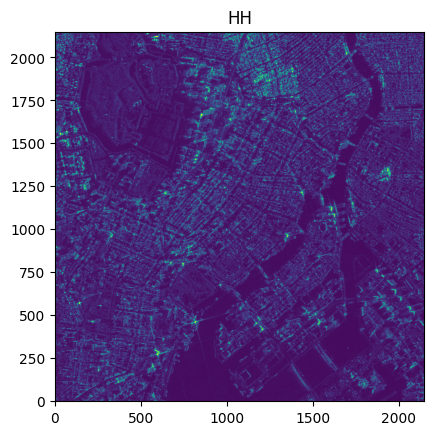

In [ ]:
plt.imshow(reprojected_data)
plt.title("HH")
plt.gca().invert_yaxis()

In [ ]:
# @title 機械学習用関数

def inference_with_patches(model, data, transform, max_batch_size=32):
    # Define stride and patch size
    stride = 256
    patch_size = 512

    # Create window for Gaussian weights
    gauss_window = np.zeros((patch_size, patch_size))
    for i in range(patch_size):
        for j in range(patch_size):
            gauss_window[i, j] = np.exp(-((i - patch_size / 2) ** 2 + (j - patch_size / 2) ** 2) / (2.0 * (patch_size / 6) ** 2))
    gauss_window = torch.from_numpy(gauss_window).float()

    # Use GPU if available
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    # gauss_window.to(device)

    # Prepare tensor for storing results and a tensor to count the overlaps
    output = torch.zeros(data.shape[0], 2, *data.shape[2:]) #.to(device)
    counts = torch.zeros(*data.shape) # .to(device)

    # List to store the patches and their indices
    patches = []
    indices = []

    # Slide over the data with stride 256
    for b in range(data.shape[0]):
        for i in range(0, data.shape[2]-stride, stride):
            for j in range(0, data.shape[3]-stride, stride):
                # Extract patch
                patch = data[b:b+1, :, i:i+patch_size, j:j+patch_size]
                patches.append(patch)
                indices.append((b, i, j))

    with torch.no_grad():
        # Iterate over patches with maximum batch size
        l = 0
        for b in range(0, len(patches), max_batch_size):
            # Select batch of patches
            patches_batch = torch.cat(patches[b:b+max_batch_size]).to(device)

            # Inference all patches in the batch at once
            # display(patches_batch.shape)
            patches_out = model(transform(patches_batch))

            # Iterate over the outputs
            for k in range(patches_out.shape[0]):
                # Get the original index of the patch
                b_orig, i, j = indices[b+k]

                # Add Gaussian weights
                patch_out_weighted = patches_out[k:k+1].detach().cpu() * gauss_window #.to(device)

                # Add to output tensor

                output[b_orig:b_orig+1, :, i:i+patch_size, j:j+patch_size] += patch_out_weighted
                counts[b_orig:b_orig+1, :, i:i+patch_size, j:j+patch_size] += gauss_window # .to(device)

    # Normalize by the counts
    output /= counts

    return output

In [ ]:
# @title 機械学習による浸水評価

def custom_normalize(image, median, std_dev):
    image = image.clamp(max=image.max() * 0.3)
    image -= image.min()
    image /= image.max()/2
    image -= 1.
    return image

normalize_transform = Lambda(lambda image: custom_normalize(image, median, 3 * std_dev))

image_transform = transforms.Compose([
    normalize_transform,
    transforms.CenterCrop(512)
])

unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=False, scale=0.5)
# 入力層だけ変える．

if polmode.lower() == "vv":
  input_ch = 1
else:
  input_ch = 2

net = nn.Sequential(
  nn.Conv2d(input_ch, 3, kernel_size=3, stride=1, padding=1, bias=False),
  unet
)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

if polmode.lower() == 'vv':
  checkpoint = torch.load(path_model+"model_epoch_vv_119.pth", map_location=device)
else:
  checkpoint = torch.load(path_model+"model_epoch_aug_mask_100.pth", map_location=device)
  print("aug")
net.load_state_dict(checkpoint)

net = net.to(device)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


In [ ]:
# 画像のサイズが512の倍数になるようにクロップ
desired_shape = [s // 512 * 512 for s in reprojected_data.shape]

assert (desired_shape[0]>0 and desired_shape[1]>0), "Processing Image size should be more than 512, please adjust bounds or resolution (meters/pixel)."

margin = [(reprojected_data.shape[i] - desired_shape[i])//2 for i in range(2)]

feed_data = reprojected_data[margin[0]:margin[0]+desired_shape[0], margin[1]:margin[1]+desired_shape[1]]

In [ ]:
tmp_feed = torch.FloatTensor(feed_data.astype(np.float32)).unsqueeze(0).unsqueeze(0)

output = inference_with_patches(net, tmp_feed, image_transform, max_batch_size)

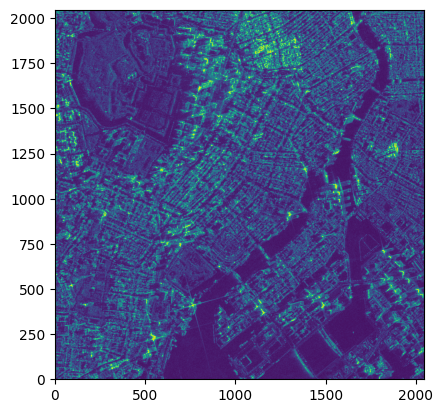

In [ ]:
plt.imshow(tmp_feed[0, 0].clamp(max=tmp_feed.max() * 0.5).numpy())
plt.gca().invert_yaxis()

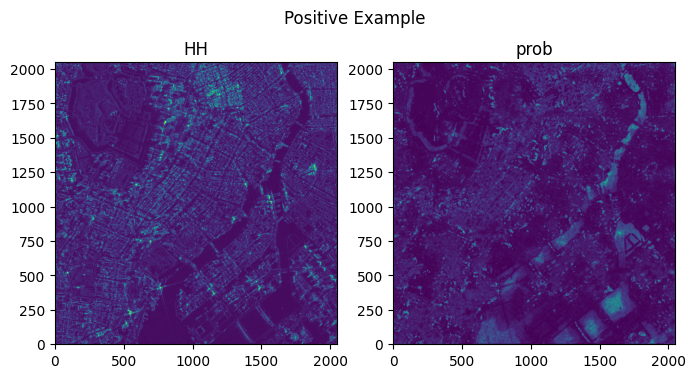

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tmp_feed[0, 0].numpy())
plt.gca().invert_yaxis()
plt.title("HH")
plt.subplot(122)
plt.imshow(torch.nn.functional.softmax(output, dim=1).numpy()[0, 1])
plt.title("prob")
plt.suptitle("Positive Example")
plt.gca().invert_yaxis()

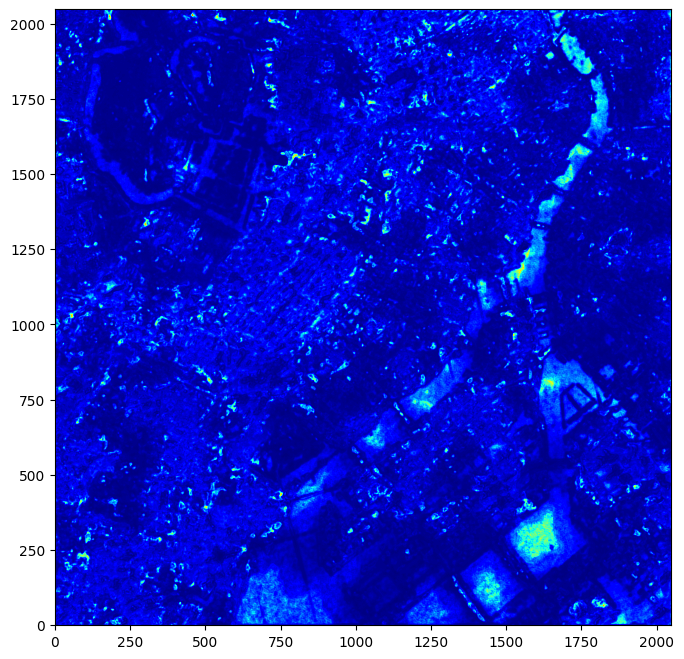

In [ ]:
p_diff = torch.nn.functional.softmax(output, dim=1).numpy()[0, 1]

plt.figure(figsize=(8, 8))
plt.imshow(p_diff, cmap='jet')
plt.gca().invert_yaxis()

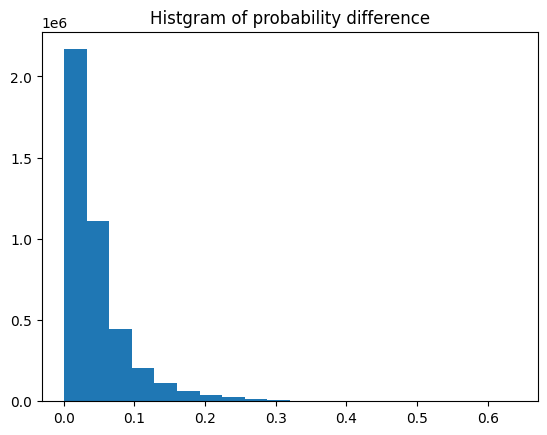

In [ ]:
plt.hist(p_diff.ravel(), bins=20);
plt.title("Histgram of probability difference");

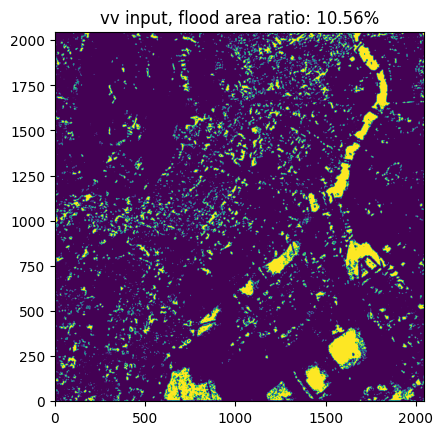

In [ ]:
threshold = 0.1

plt.imshow(p_diff > threshold)
plt.title(f"vv input, flood area ratio: {(100 * (p_diff > threshold).sum() / p_diff.ravel().shape).item():1.2f}%")
plt.gca().invert_yaxis()

In [ ]:
torch.save(output, file_prb)
np.save(file_fldbbox , boundbox)